In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
# %matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import pyccl as ccl


%load_ext autoreload
%autoreload 2




/tmp/ipykernel_2471192/2477179059.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo = ccl.Cosmology(
    Omega_c=0.31-0.049, Omega_b=0.049, h=0.672, sigma8=0.81, n_s=0.95,
    transfer_function='eisenstein_hu')



In [3]:
k_array_ccl = np.logspace(-4, 2, 100)
z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl, a=1/(1+z))



In [4]:
from pyccl.halos.profiles import nfw
from pyccl.halos.concentration import duffy08



In [5]:
conc_model_ccl = duffy08.ConcentrationDuffy08()
nfw_prof_ccl = nfw.HaloProfileNFW(mass_def='200c',concentration=conc_model_ccl)



In [6]:
r_array = np.logspace(-2, 0, 100)
z_test = 0.0
h = cosmo['h']
M_test = 1.07710506e+14
conc = conc_model_ccl._concentration(cosmo,M_test/h,1/(1+z_test))



In [7]:
prof_test_ccl = nfw_prof_ccl._real(cosmo,r_array/h,M_test/h,1/(1+z_test))/(h**2)



In [167]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 5.0
sim_params_dict['delta_rhogas'] = 9.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.01
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.0
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 15.1
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.1
sim_params_dict['eta_cga'] = 0.7


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 24, 256
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
halo_params_dict['nz'] = len(halo_params_dict['z_array'])
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 10.0, 16.0, 64
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 8, 16
halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**15, 64
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.01
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open('/mnt/home/spandey/ceph/GODMAX/data/sim_3x2pt_simulated_DV_PKproject_values_bestfit_maglim_3x2LCDM_final.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = False

df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DES_ACT_full_data_theorycov_2.5.fits')
theta_data = df_data['compton_shear'].data['ANG'][0:20]

analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = False
analysis_dict['calc_nfw_only'] = True





In [152]:
from get_BCMP_profile_jit import BCM_18_wP
BCMP_test = BCM_18_wP(sim_params_dict, halo_params_dict)



In [164]:
Mdmb_int = BCMP_test.Mdmb_mat[-1,...] 
Mtot = BCMP_test.Mtot_mat



In [166]:
# Mtot.shape, Mdmb_int.shape
Mtot[10,0,:]/Mdmb_int[10,0,:]



Array([1.17023976, 1.11969544, 1.08110157, 1.05123675, 1.02796929,
       1.00980394, 0.99566917, 0.98477763, 0.97652073, 0.97041917,
       0.96610028, 0.96326086, 0.96163926, 0.96102691, 0.96125096,
       0.96124211, 0.96159336, 0.96264959, 0.96425701, 0.96628802,
       0.96863609, 0.97121191, 0.97394051, 0.97675902, 0.97961491,
       0.98246445, 0.98527189, 0.98800802, 0.99064925, 0.99317738,
       0.99557883, 0.99784363, 0.99996545, 1.00194086, 1.00376871,
       1.00545005, 1.0069873 , 1.00838429, 1.00964598, 1.01077781,
       1.01178606, 1.01267689, 1.01345694, 1.01413277, 1.01471103,
       1.01519831, 1.01560123, 1.01592652, 1.01618119, 1.01637261,
       1.01650883, 1.01659887, 1.01665315, 1.01668392, 1.01670588,
       1.01673689, 1.01679874, 1.01691812, 1.01712756, 1.01746654,
       1.01798254, 1.01873218, 1.0197821 , 1.02120969], dtype=float64)

In [153]:
# BCMP_test.Mtot_mat.shape
# BCMP_test.rho_dmb_mat.shape
# BCMP_test.rho_dmb_mat[:,indc, indz, indM]
# indc, indz, indM


In [154]:
# import scipy.integrate as integrate
# Rh = 0.1
# r_array = np.linspace(0.01, 100, 1000)
# func = (1/(4 * np.pi**1.5 * Rh)) * (1/r_array**2) * np.exp(-1 * (r_array/(2*Rh))**2)
# integrate.simps(func, r_array)



In [155]:
# BCMP_test.rho_dmb_mat.shape
import scipy.integrate as integrate
indz = 2
indc = 10
indM = 30
rho_cga_j = BCMP_test.rho_cga_mat[:,indc, indz, indM]
rho_clm_j = BCMP_test.rho_clm_mat[:,indc, indz, indM]
rho_gas_j = BCMP_test.rho_gas_mat[:,indc, indz, indM]
rho_dmb_j = BCMP_test.rho_dmb_mat[:,indc, indz, indM]
rho_nfw_j = BCMP_test.rho_nfw_mat[:,indc, indz, indM]
r_array_j = BCMP_test.r_array
# M_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mcga_int_j = integrate.simps(4 * np.pi * rho_cga_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mclm_int_j = integrate.simps(4 * np.pi * rho_clm_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mgas_int_j = integrate.simps(4 * np.pi * rho_gas_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mdmb_int_j = integrate.simps(4 * np.pi * rho_dmb_j * r_array_j**2 * r_array_j, np.log(r_array_j))
Mnfw_int_j = integrate.simps(4 * np.pi * rho_nfw_j * r_array_j**2 * r_array_j, np.log(r_array_j))
# print(Mdmb_int_j/BCMP_test.Mtot_mat[indc, indz, indM])
# print(Mnfw_int_j/BCMP_test.Mtot_mat[indc, indz, indM])



In [156]:
print(Mcga_int_j/BCMP_test.Mtot_mat[indc, indz, indM], BCMP_test.fcga_array[indM])
print(Mclm_int_j/BCMP_test.Mtot_mat[indc, indz, indM], BCMP_test.fclm_array[indM])
print(Mgas_int_j/BCMP_test.Mtot_mat[indc, indz, indM], BCMP_test.fgas_array[indM])




0.004996855140923511 0.008594933274192923
0.9014445144059461 0.8976875387118534
0.0937174997888229 0.09371752801395374


In [14]:
# BCMP_test.fstar_array[indM]
# BCMP_test.zeta_mat[:,indc, indz, indM]



In [15]:
indc = np.where(BCMP_test.conc_array > 0.95*conc)[0][0]
indz = np.where(BCMP_test.z_array > 0.95*z_test)[0][0]
indM = np.where(BCMP_test.M_array > 0.95*M_test)[0][0]



(1000000000000.0, 20000000000000.0)

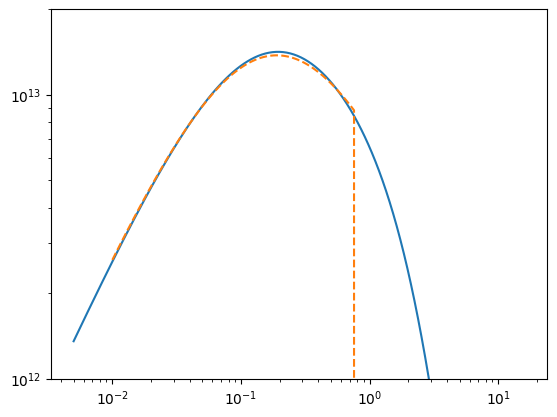

In [16]:
pl.figure()
pl.loglog(BCMP_test.r_array, (BCMP_test.r_array**2)*BCMP_test.rho_nfw_mat[:,indc,indz,indM])
pl.loglog(r_array, (r_array**2)*prof_test_ccl, '--')
pl.ylim(1e12, 2e13)




In [173]:
from setup_power_spectra_jit import setup_power_BCMP

setup_power_BCMP_test = setup_power_BCMP(sim_params_dict, halo_params_dict, analysis_dict, num_points_trapz_int=64, verbose_time=True)




Time taken to calculate BCMP profile:  5.188401699066162  seconds
Time taken to setup Pk:  2.4638304710388184
Time taken to setup HMF:  5.227185249328613
Time taken to setup uks and bks:  1.1972668170928955
Time taken to setup uls and bls:  1.0385735034942627
Time taken to setup power spectra:  10.735444068908691


In [158]:
# setup_power_BCMP_test.bias_Mz_mat.shape
# setup_power_BCMP_test.uk_nfw[:,0,0,40]
# setup_power_BCMP_test.uk_dmb[:,0,0,40]

# Pk_dmb


In [174]:
# Pk_nfw = (setup_power_BCMP_test.bm_nfw_kz_mat)**2 * setup_power_BCMP_test.plin_kz_mat +  setup_power_BCMP_test.Pmm_nfw_1h_mat
Pk_nfw = setup_power_BCMP_test.Pmm_nfw_tot_mat
Pk_dmb = setup_power_BCMP_test.Pmm_dmb_tot_mat
Pk_sup = setup_power_BCMP_test.Pmm_sup_tot_mat


Pk_sup2 = (setup_power_BCMP_test.plin_kz_mat +  setup_power_BCMP_test.Pmm_dmb_1h_mat)/(setup_power_BCMP_test.plin_kz_mat +  setup_power_BCMP_test.Pmm_nfw_1h_mat)



In [175]:
k_array_ccl = setup_power_BCMP_test.k
z = z_test
# z = 0.0
pkz_HF_ccl = ccl.nonlin_matter_power(cosmo, k=k_array_ccl*h, a=1/(1+z)) * h**3






In [176]:
# indz = 0
# pl.figure()
# pl.loglog(k_array_ccl, (k_array_ccl**3)*Pk_nfw[:,indz])
# pl.loglog(k_array_ccl, (k_array_ccl**3)*Pk_dmb[:,indz], ls=':')
# pl.loglog(k_array_ccl, (k_array_ccl**3)*setup_power_BCMP_test.plin_kz_mat[:,indz])
# pl.loglog(k_array_ccl, (k_array_ccl**3)*pkz_HF_ccl, '--')
# pl.grid()




(0.9, 1.05)

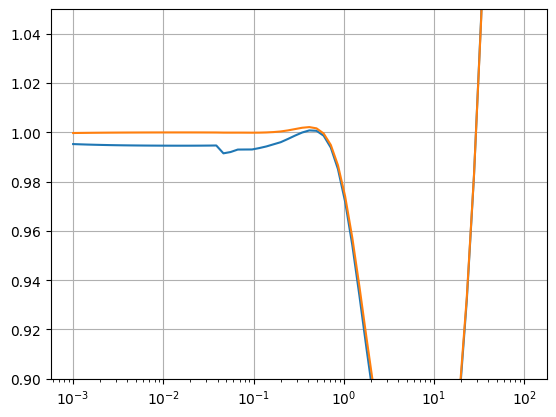

In [177]:
indz = 0
pl.figure()
pl.plot(k_array_ccl, Pk_sup[:,indz])
pl.plot(k_array_ccl, Pk_sup2[:,indz])
pl.xscale('log')
pl.grid()
pl.ylim(0.9,1.05)


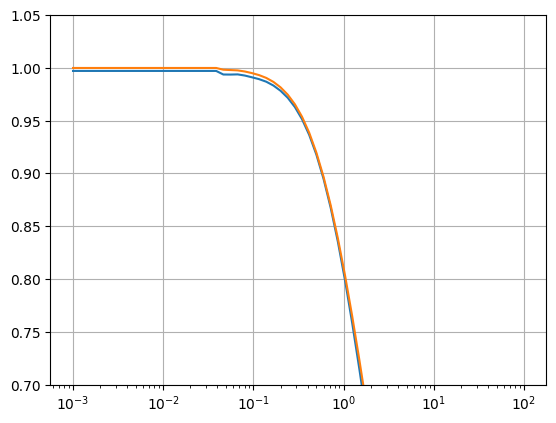

In [178]:
# setup_power_BCMP_test.bm_dmb_kz_mat.shape
pl.figure()
pl.plot(k_array_ccl, setup_power_BCMP_test.bm_dmb_kz_mat[:,0])
pl.plot(k_array_ccl, setup_power_BCMP_test.bm_nfw_kz_mat[:,0])
# pl.plot(k_array_ccl, setup_power_BCMP_test.bm_dmb_2h[:,0] + (1 - setup_power_BCMP_test.bm_largescales_2h_mat[:,0]))
# pl.plot(k_array_ccl, setup_power_BCMP_test.bm_dmb_2h[:,0])
# pl.plot(k_array_ccl, setup_power_BCMP_test.bm_largescales_2h_mat[:,0], ls='--')
pl.xscale('log')
pl.ylim(0.7,1.05)
# pl.loglog(k_array_ccl, (k_array_ccl**3)*setup_power_BCMP_test.plin_kz_mat[:,indz])
# pl.loglog(k_array_ccl, (k_array_ccl**3)*pkz_HF_ccl, '--')
pl.grid()



In [69]:
setup_power_BCMP_test.bm_dmb_kz_mat[:,0]


Array([0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 ,
       0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 ,
       0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 ,
       0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 , 0.9945328 ,
       0.9945328 , 0.98914397, 0.9893083 , 0.98857626, 0.98788108,
       0.98683507, 0.98526245, 0.98318068, 0.98011823, 0.97600214,
       0.97024629, 0.96255088, 0.95223443, 0.93880252, 0.92160442,
       0.90024582, 0.87444334, 0.84430833, 0.81024758, 0.77299513,
       0.73342192, 0.69244383, 0.6509344 , 0.60971181, 0.56950856,
       0.53095545, 0.49458156, 0.46079107, 0.42985011, 0.40186822,
       0.37682001, 0.35458488, 0.33501617, 0.31796874, 0.30328963,
       0.29079151, 0.28026279, 0.27148177, 0.26422915, 0.25829028,
       0.25346276, 0.24955964, 0.24641546, 0.24453809], dtype=float64)

In [1]:
# ws_55_04_mu_6_90_dT_7_80_n_1_BH_DensTh_m_2_24
import re

def extract_specific_values(input_string):
    # Dictionary to store the extracted values
    values = {}

    # Patterns for each specific variable
    patterns = {
        'ws': r'ws_([0-9]+(?:\.[0-9]+)?)',
        'mu': r'mu_([0-9]+(?:\.[0-9]+)?)',
        'dT': r'dT_([0-9]+(?:\.[0-9]+)?)',
        'n': r'n_([0-9]+(?:\.[0-9]+)?)',
        'BH_DensTh_m': r'BH_DensTh_m_([0-9]+(?:\.[0-9]+)?)'
    }

    # Extract each variable
    for key, pattern in patterns.items():
        match = re.search(pattern, input_string)
        if match:
            values[key] = float(match.group(1))

    return values

# Example usage
input_string = "ws_55_04_mu_6_90_dT_7_80_n_1_BH_DensTh_m_2_24"
extracted_values = extract_specific_values(input_string)
print(extracted_values)



{'ws': 55.0, 'mu': 6.0, 'dT': 7.0, 'n': 1.0, 'BH_DensTh_m': 2.0}
